In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import rioxarray
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm
import copy
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white

def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def label_csv_2(clean_img_path):
    #only for saturday and sunday
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        if find_day(date_string) == 'Saturday' or find_day(date_string) == 'Sunday':
            df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
            
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
        try:
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image

def extract_random_patches(image, patch_size=(10, 10), num_patches=10, threshold=50):
    patches = []
    image_height, image_width = image.shape[:2]
    patch_height, patch_width = patch_size

    
    while len(patches) < num_patches:
        # Generate random coordinates for the top-left corner of the patch
        start_h = np.random.randint(0, image_height - patch_height + 1)
        start_w = np.random.randint(0, image_width - patch_width + 1)
        
        # Extract the patch using slicing
        patch = image[start_h:start_h + patch_height, start_w:start_w + patch_width]
        if (patch == 0).sum()/(patch_height*patch_height*3) < threshold/100:  #removes black patches
            patches.append(patch)
        else:
            pass
    
    return patches

def extract_patches(image, patch_size=10, threshold=50):

    patches = []
    height, width, channels = image.shape

    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            patch = image[y:y + patch_size, x:x + patch_size]  # Extract patch
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size is correct
                if (patch == 0).sum()/(patch_size*patch_size*3) < threshold/100:  #removes black patches
                    patches.append(patch)

    return patches

In [3]:
img_path = "/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_538_bbox/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)
masked_clean = [i for i in clean_3 if 'Masked' in i]
square_clean = [i for i in clean_3 if 'Planet' in i]

Initial size of dataset 500
Most common size of the dataset (4, 123, 39)
Final size of dataset(after removing faulty size images) 498
Final size of dataset(after removing faulty black pixels in images) 487
Final size of dataset(after removing faulty white pixels in images) 332


(123, 39, 3)
10


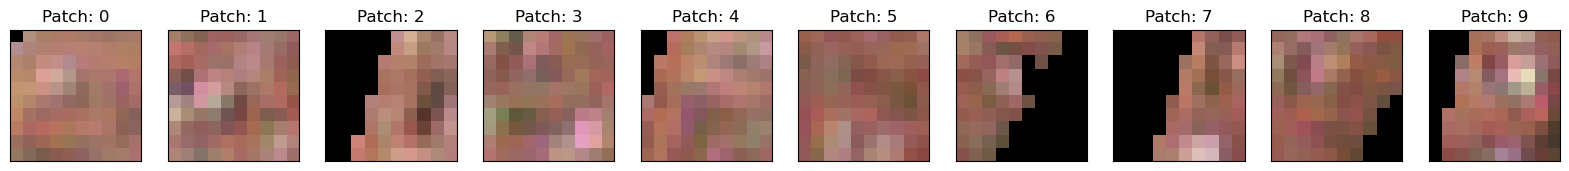

In [4]:
img = rioxarray.open_rasterio(masked_clean[42]).data[0:3].transpose(1, 2, 0)
print(img.shape)
patches = extract_patches(img, patch_size=10, threshold=50)
print(len(patches))
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(patches[i])
    plt.title(f'Patch: {i}')
    plt.xticks([])
    plt.yticks([])

##### Method 1: Sat vs Sunday

In [5]:
df = label_csv_2(masked_clean)
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

Class distribution in dataset: 1    29
0    26
Name: label, dtype: int64
Train size: (44, 3)
Test size: (11, 3)
Train class distribution: 1    23
0    21
Name: label, dtype: int64
Test class distribution: 1    6
0    5
Name: label, dtype: int64


In [18]:
import os
path2new_data = '/home/akansh-i2sc/Desktop/Project/detect-car-LR/notebooks/Exp_8/patch_data_single_parking_lot_satvsun_10m/'

def create_dataset(path2new_data, train, test, patch_size):
    if not os.path.exists(path2new_data):
        os.mkdir(path2new_data)
        os.mkdir(os.path.join(path2new_data, 'train'))
        os.mkdir(os.path.join(path2new_data, 'test'))
        os.mkdir(os.path.join(path2new_data, 'train', '0'))
        os.mkdir(os.path.join(path2new_data, 'train', '1'))
        os.mkdir(os.path.join(path2new_data, 'test', '0'))
        os.mkdir(os.path.join(path2new_data, 'test', '1'))
    else:
        pass

    for i in tqdm(range(len(train))):
        img_path = train.image_path.values[i]
        img = rioxarray.open_rasterio(img_path)
        img = img.data[0:3].transpose(1, 2, 0)
        patches = extract_patches(img, patch_size=patch_size, threshold=50)
        label = train.label.values[i]
        if label == 0:
            for j in range(len(patches)):
                plt.imsave(os.path.join(path2new_data, 'train', '0', f'{i}_{j}.png'), patches[j])
        else:
            for j in range(len(patches)):
                plt.imsave(os.path.join(path2new_data, 'train', '1', f'{i}_{j}.png'), patches[j])

    for i in tqdm(range(len(test))):
        img_path = test.image_path.values[i]
        img = rioxarray.open_rasterio(img_path)
        img = img.data[0:3].transpose(1, 2, 0)
        patches = extract_patches(img, patch_size=patch_size, threshold=50)
        label = test.label.values[i]
        if label == 0:
            for j in range(len(patches)):
                plt.imsave(os.path.join(path2new_data, 'test', '0', f'{i}_{j}.png'), patches[j])
        else:
            for j in range(len(patches)):
                plt.imsave(os.path.join(path2new_data, 'test', '1', f'{i}_{j}.png'), patches[j])

create_dataset(path2new_data, train, test)


<Figure size 2000x2000 with 0 Axes>

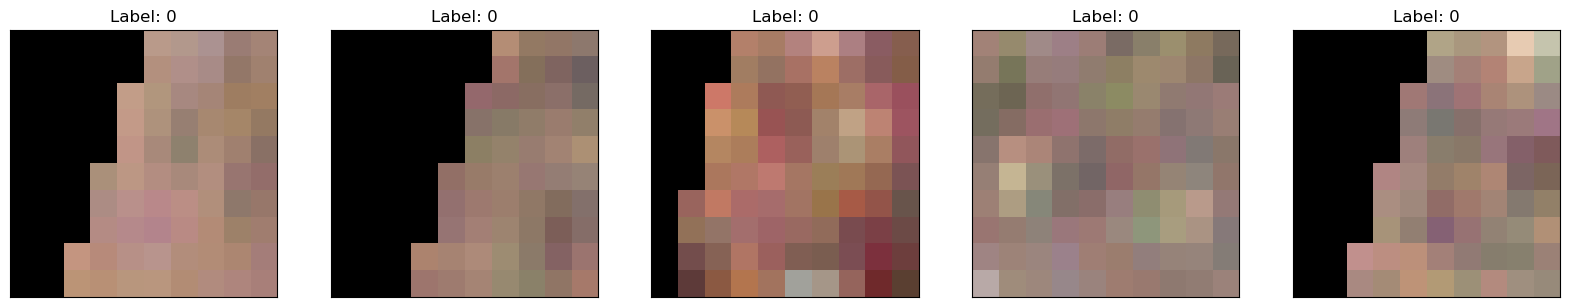

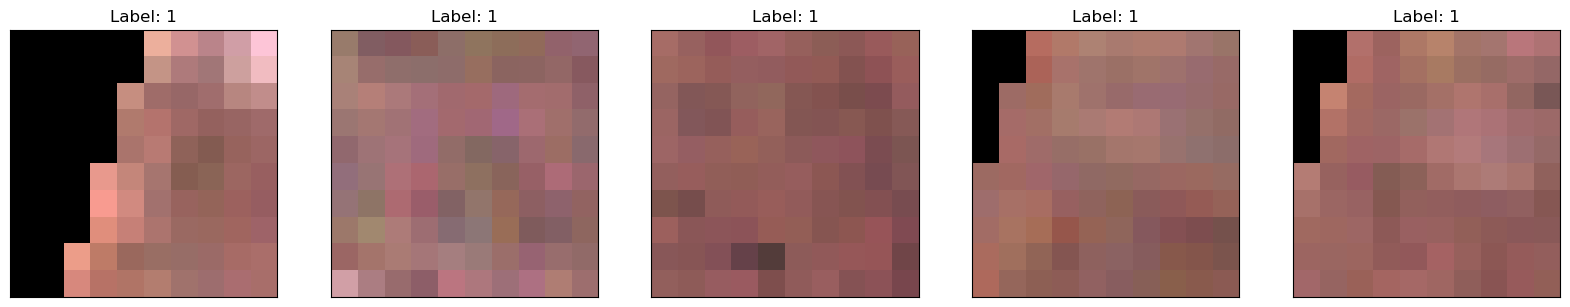

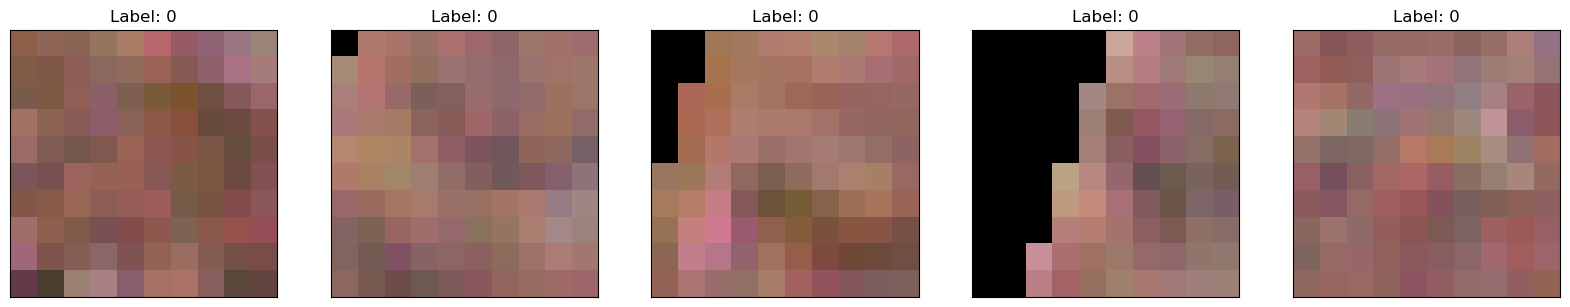

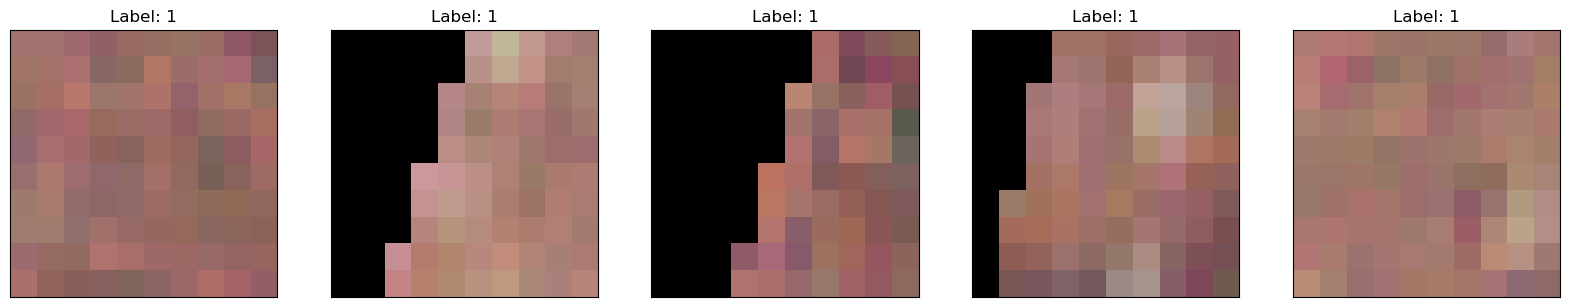

In [7]:
plt.figure(figsize=(20,20))
train_img_0 = glob.glob(os.path.join(path2new_data, 'train', '0', '*.png'))
train_img_1 = glob.glob(os.path.join(path2new_data, 'train', '1', '*.png'))

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(train_img_0[i])
    plt.imshow(img)
    plt.title(f'Label: 0')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(train_img_1[i])
    plt.imshow(img)
    plt.title(f'Label: 1')
    plt.xticks([])
    plt.yticks([])

#plotting the patches from the testset of both categories and putting them in a grid with labels
test_img_0 = glob.glob(os.path.join(path2new_data, 'test', '0', '*.png'))
test_img_1 = glob.glob(os.path.join(path2new_data, 'test', '1', '*.png'))

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(test_img_0[i])
    plt.imshow(img)
    plt.title(f'Label: 0')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(test_img_1[i])
    plt.imshow(img)
    plt.title(f'Label: 1')
    plt.xticks([])
    plt.yticks([])


#### Training 

In [8]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss = []
    train_acc = []
    train_auc = []
    val_loss = []
    val_acc = []
    val_auc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            y_pred = []
            y_true = []
            # Iterate over data.
            for inputs, labels in eval(phase+'_loader'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
            epoch_loss = running_loss / len(eval(phase+'_loader').dataset)
            epoch_acc = running_corrects.double() / len(eval(phase+'_loader').dataset)
            epoch_auc = roc_auc_score(y_true, y_pred)
            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_auc))
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_auc.append(epoch_auc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                val_auc.append(epoch_auc)
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                # torch.save(model.state_dict(), '"patch_based_model_individial_parking.pt')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val AUC: {:4f}'.format(best_auc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc

def inference(img, model, test_transform):
    model.eval()
    img = test_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    output = model(img)
    _, preds = torch.max(output, 1)
    return preds.item()

def inference_by_voting(img, patch_size = 10):
    img = rioxarray.open_rasterio(img)
    img = img.data[0:3].transpose(1, 2, 0)
    patches = extract_patches(img, patch_size=patch_size, threshold=50)
    preds = []
    for i in patches:
        preds.append(inference(i, model, test_transform))
    # print(preds)
    # print(max(set(preds), key=preds.count))
    return max(set(preds), key=preds.count)


train_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'train'), transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'test'), transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
----------
train Loss: 0.7900 Acc: 0.5341 AUC: 0.5183
test Loss: 0.7042 Acc: 0.5000 AUC: 0.4800
Epoch 1/199
----------
train Loss: 0.7066 Acc: 0.5614 AUC: 0.5504
test Loss: 0.7130 Acc: 0.4727 AUC: 0.4417
Epoch 2/199
----------
train Loss: 0.7007 Acc: 0.5659 AUC: 0.5676
test Loss: 0.7063 Acc: 0.5455 AUC: 0.5000
Epoch 3/199
----------
train Loss: 0.7106 Acc: 0.5136 AUC: 0.5170
test Loss: 0.7054 Acc: 0.5091 AUC: 0.4733
Epoch 4/199
----------
train Loss: 0.6743 Acc: 0.5727 AUC: 0.5694
test Loss: 0.7031 Acc: 0.4636 AUC: 0.4417
Epoch 5/199
----------
train Loss: 0.6805 Acc: 0.6045 AUC: 0.5986
test Loss: 0.6959 Acc: 0.5000 AUC: 0.4667
Epoch 6/199
----------
train Loss: 0.6974 Acc: 0.5568 AUC: 0.5500
test Loss: 0.6837 Acc: 0.5455 AUC: 0.5050
Epoch 7/199
----------
train Loss: 0.6830 Acc: 0.5955 AUC: 0.5878
test Loss: 0.6729 Acc: 0.5455 AUC: 0.5050
Epoch 8/199
----------
train Loss: 0.6866 Acc: 0.5614 AUC: 0.5550
test Loss: 0.6646 Acc: 0.5545 AUC: 0.5150
Epoch 9/199
----------
train

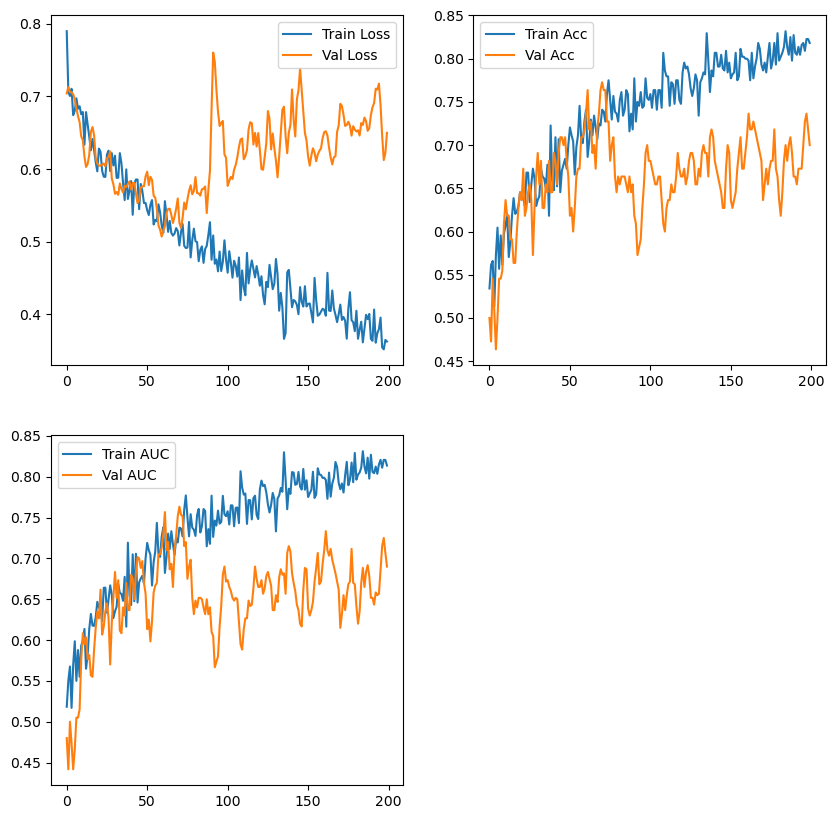

In [11]:
train_acc_values = []
for index in range(len(train_acc)):
    train_acc_values.append(train_acc[index].item())

val_acc_values = []
for index in range(len(val_acc)):
    val_acc_values.append(val_acc[index].item())

#plotting the loss and accuracy curves, AUC scores for train and test set
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(train_acc_values, label='Train Acc')
plt.plot(val_acc_values, label='Val Acc')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Val AUC')
plt.legend()
plt.show()

#### Patch_size_experiment

In [19]:
df = label_csv_2(masked_clean)
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

Class distribution in dataset: 1    29
0    26
Name: label, dtype: int64
Train size: (44, 3)
Test size: (11, 3)
Train class distribution: 1    23
0    21
Name: label, dtype: int64
Test class distribution: 1    6
0    5
Name: label, dtype: int64


In [ ]:
patch_size_list = [5,10,15,20,25,30,35,40,45,50]
AUC_patch = []
try: 
    for patch_size in patch_size_list:

        path2new_data = f'/home/akansh-i2sc/Desktop/Project/detect-car-LR/notebooks/Exp_8/patch_data_single_parking_lot_satvsun_{patch_size}m/'
        create_dataset(path2new_data, train, test, patch_size=patch_size)

        train_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'train'), transform=train_transform)
        test_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'test'), transform=test_transform)
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        model = torchvision.models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(512, 2)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=0.0001)
        model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=200)
        AUC_patch.append(np.max(val_auc))
        test[f'pred_label_patch_{patch_size}'] = test.image_path.apply(lambda x: inference_by_voting(x, patch_size=patch_size))
except:
    pass


Text(0, 0.5, 'Values-AUC/Accuracy')

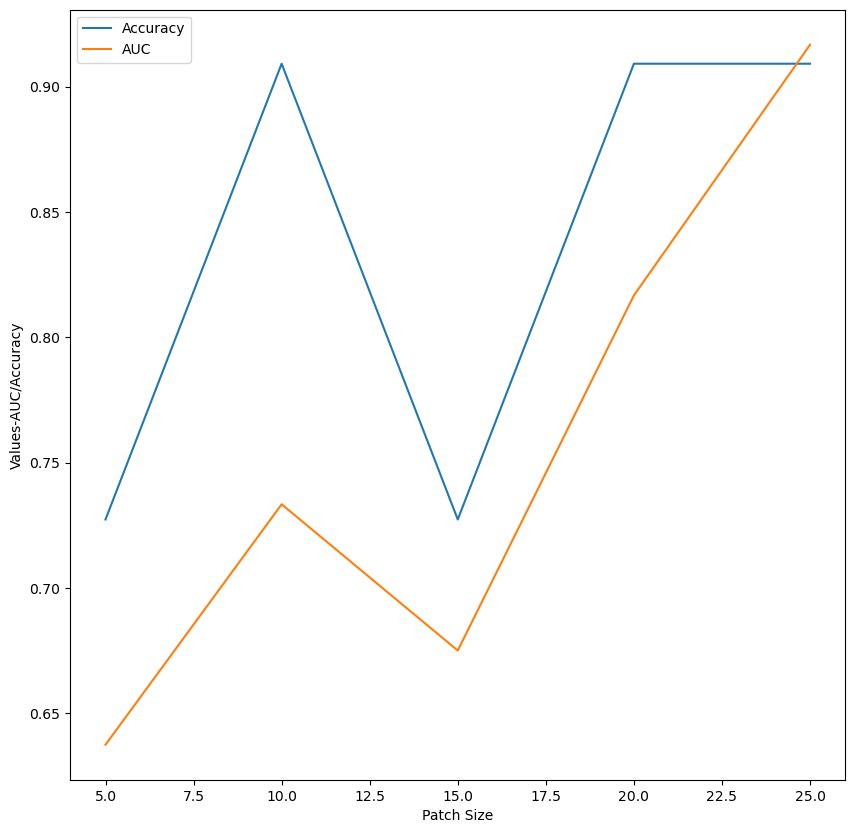

In [42]:
#calculate accracy for different patch sizes and plot the results
accuracy_patch = []
try: 
    for patch_size in patch_size_list:
        accuracy_patch.append(accuracy_score(test.label.values, test[f'pred_label_patch_{patch_size}'].values))
except:
    pass
plt.figure(figsize=(10, 10))
plt.plot(patch_size_list[:len(accuracy_patch)], accuracy_patch, label='Accuracy')
plt.plot(patch_size_list[:len(accuracy_patch)], AUC_patch, label='AUC')
plt.legend()
plt.xlabel('Patch Size')
plt.ylabel('Values-AUC/Accuracy')
